In [1]:
%matplotlib inline
%load_ext lab_black

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import missingno as msno

sklearn.set_config(enable_metadata_routing=True)
from sklearn.metrics import (
    mean_absolute_error as MAE,
    mean_squared_error as RMSE,
    r2_score as R2,
    make_scorer,
)
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.model_selection import (
    GridSearchCV,
    ParameterGrid,
    ShuffleSplit,
    train_test_split,
)
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from shared import process_multi_site
from tensorflow import keras
from plot import model_list, pred_plot, err_plot, error_per_month_and_site, plot_metrics
from model import (
    load_data,
    train_and_test,
    display_graph,
    PickleableKerasRegressor,
    HistoryKerasRegressor,
    dnn_gen,
    reload_model,
)
from sklearn.pipeline import Pipeline
import time
from pickle import dump

resources = "resources/"
sites_path = os.path.join(resources, "fdk_site_info.csv")
data_path = os.path.join(resources, f"ENF_all.tar.gz")
predictions_path = os.path.join(resources, "predictions_weighted.csv.gz")
results_path = os.path.join(resources, "results_weighted.csv")
results_standard_path = os.path.join(resources, "results.csv")

# Models with sample weight

In [2]:
df_raw = process_multi_site(
    data_path,
    sites_path,
    keep_qc=True,
    rolling_variables=["P_F", "TA_F_MDS", "VPD_F_MDS", "TA_F_MDS_QC"],
)
df_raw.shape

Loading the data
Loading metadata and joining
Adding GPP and GPP_diff
Dropping unused features
Removing bad values
Adding rolling window features
Processing P_F_1w...
Processing P_F_4w...
Processing TA_F_MDS_1w...
Processing TA_F_MDS_4w...
Processing VPD_F_MDS_1w...
Processing VPD_F_MDS_4w...
Processing TA_F_MDS_QC_1w...
Processing TA_F_MDS_QC_4w...
Adding engineered features
Remove unused features
NA: 133222


(224641, 41)

In [3]:
def process_qc(df):
    df["weights"] = (
        2 * df["TA_F_MDS_QC_1w"]
        + 1 * df["TA_F_MDS_QC_4w"]
        + 4 * df["TA_F_MDS_QC"]
        + 2 * df["SW_IN_F_MDS_QC"]
        + 5 * df["NEE_VUT_REF_QC"]
        + 2 * df["LE_F_MDS_QC"]
        + 0 * np.maximum(20 - df["GPP_diff"].abs(), 0) / 20
    )
    df["weights_2"] = df["weights"] * ((df["GPP"] ** 2) + 1)
    return df[
        [
            f
            for f in df.columns.values
            if not f.endswith(("_QC", "_QC_1w", "_QC_4w", "_diff"))
        ]
    ]

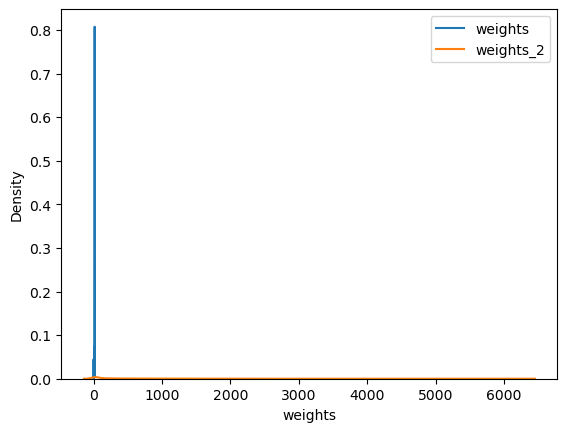

In [4]:
df = process_qc(df_raw)
sns.kdeplot(df["weights"], label="weights")
sns.kdeplot(df["weights_2"], label="weights_2")
plt.legend()
plt.show()

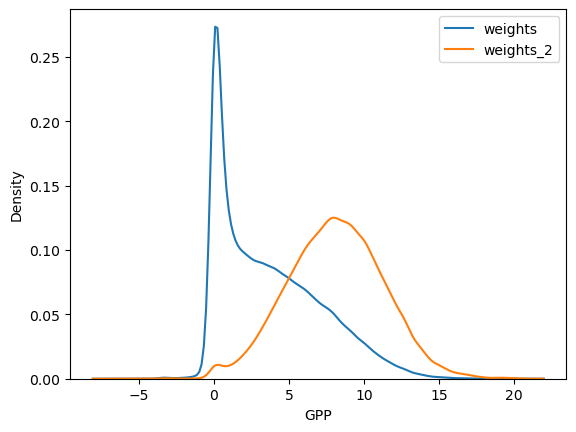

In [5]:
df = process_qc(df_raw)
sns.kdeplot(df["GPP"], label="weights", weights=df["weights"])
sns.kdeplot(df["GPP"], label="weights_2", weights=df["weights_2"])
plt.legend()
plt.show()

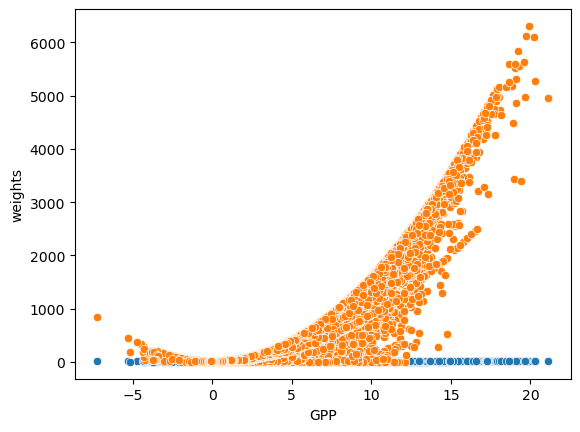

In [6]:
sns.scatterplot(x="GPP", y="weights", data=df)
sns.scatterplot(x="GPP", y="weights_2", data=df)
plt.show()

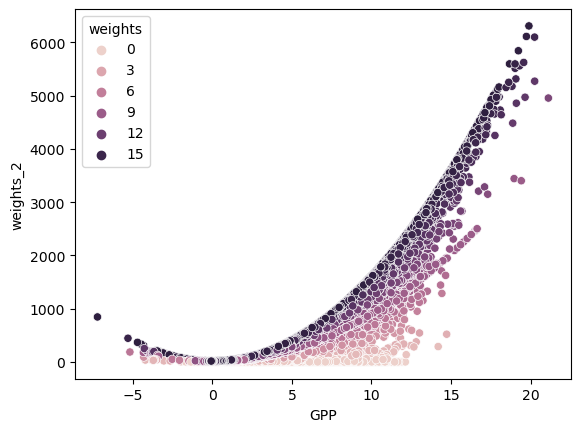

In [7]:
sns.scatterplot(x="GPP", y="weights_2", data=df, hue="weights")
plt.show()

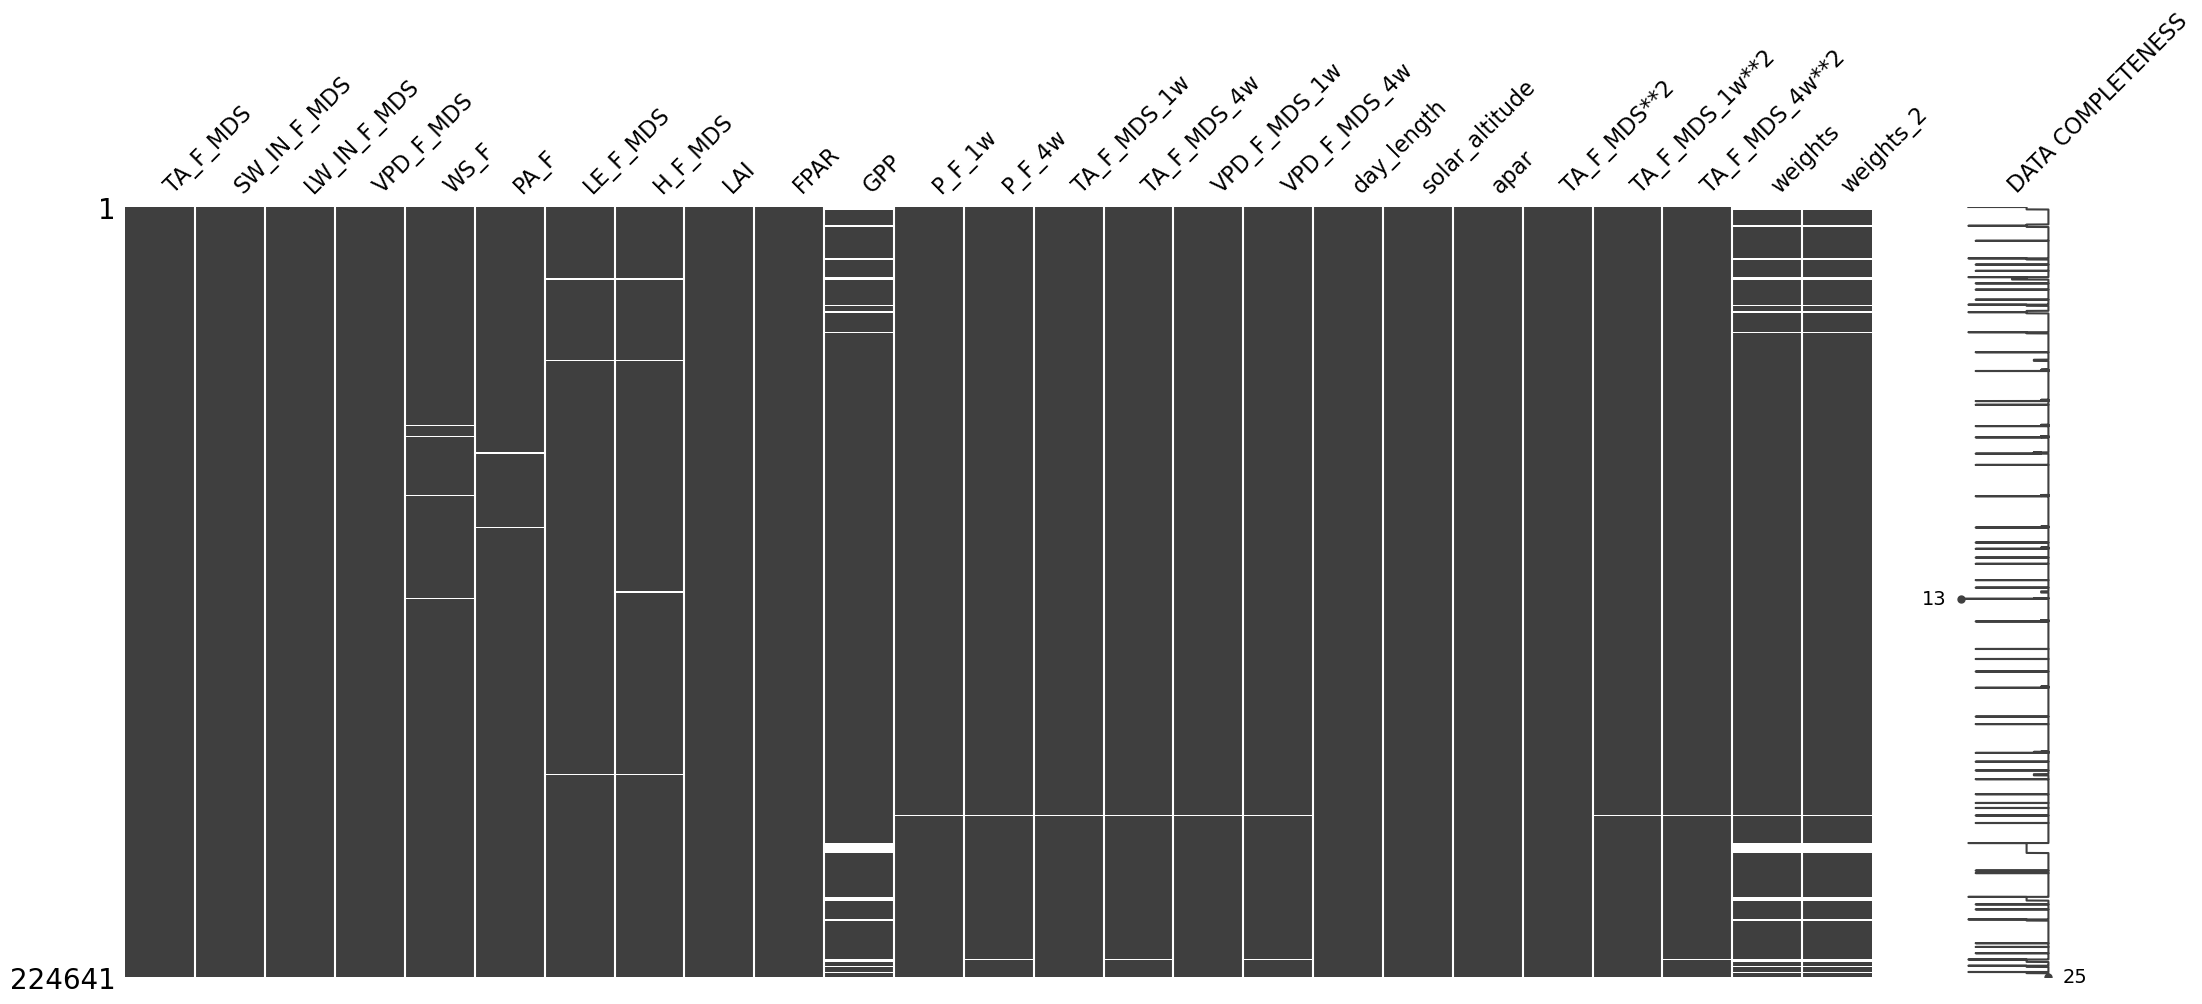

NA: 12807


In [8]:
msno.matrix(df, labels=True)
plt.show()
print(f"NA: {(df.isna().any(axis=1)).sum()}")

In [9]:
df.dropna(inplace=True)
df.shape

C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(211834, 25)

In [10]:
tv_split, test_split = train_test_split(df, test_size=0.3, random_state=0)
print(f"Test/validate: {tv_split.shape}")
print(f"Train: {test_split.shape}")

Test/validate: (148283, 25)
Train: (63551, 25)


In [11]:
def split(d):
    return (
        d.drop(["GPP", "weights", "weights_2"], axis=1),
        d["GPP"],
        d["weights"].to_numpy(),
        d["weights_2"].to_numpy(),
    )

In [12]:
X_tv, y_tv, sample_weights_tv, sample_weights_tv_2 = split(tv_split)
X_test, y_test, sample_weights_test, _ = split(test_split)

In [13]:
def compute_metrics(model, y_transform, X, y, sample_weights, label="", verbose=True):
    if verbose:
        print("----")
        print(f"Predicting {label}...")
    start = time.time()
    y_pred_raw = model.predict(X).reshape(-1, 1)
    y_pred = y_transform.inverse_transform(y_pred_raw)
    end = time.time()
    pred_time = round(end - start, 2)
    # Compute the metrics
    r2 = R2(y, y_pred, sample_weight=sample_weights).round(2)
    mae = MAE(y, y_pred, sample_weight=sample_weights).round(2)
    rmse = RMSE(y, y_pred, sample_weight=sample_weights).round(2)
    # Print
    if verbose:
        print(f"Prediction time: {pred_time}s")
        print(f"Score ({label}): {r2}")
        print(f"MAE ({label}): {mae}")
        print(f"RMSE ({label}): {rmse}")
    return y_pred, pred_time, r2, mae, rmse

In [14]:
# Train a griven model, compute the metrics on the train/validation and test sets,
# and persist the model to disk for later use.
def train_and_test(
    model_name,
    model,
    y_transform,
    X_tv,
    y_tv,
    sample_weights_tv,
    X_test,
    y_test,
    sample_weights_test,
):
    # Fit the model
    start = time.time()
    y_tv_trans = y_transform.fit_transform(y_tv.to_frame()).ravel()
    model.fit(X_tv, y_tv_trans, sample_weight=sample_weights_tv)
    end = time.time()
    train_time = round(end - start, 2)
    # Print mean fit time
    print(f"Total training time: {train_time}s")
    try:
        cv_results = pd.DataFrame(model.cv_results_)
        print(f"Mean fit time: {cv_results['mean_fit_time'].mean().round(2)}s")
    except:
        pass
    # Compute the metrics
    _, pred_time_train, r2_train, mae_train, rmse_train = compute_metrics(
        model, y_transform, X_tv, y_tv, sample_weights_tv, "train"
    )
    y_pred_test, pred_time_test, r2_test, mae_test, rmse_test = compute_metrics(
        model, y_transform, X_test, y_test, sample_weights_test, "test"
    )
    if model_name:
        # Persist model to disk
        with open(os.path.join(resources, f"{model_name}.pkl"), "wb") as f:
            dump(model, f, protocol=5)
    res = {
        "model": model_name,
        "pred_time_train": pred_time_train,
        "R2_train": r2_train,
        "MAE_train": mae_train,
        "RMSE_train": rmse_train,
        "pred_time_test": pred_time_test,
        "R2_test": r2_test,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
    }
    return y_pred_test, res

In [15]:
def eval_model(
    name,  # Model name
    regressor,  # Regressor to use in the pipeline
    grid,  # Parameter grid
    X_tv,
    y_tv,
    sample_weights_tv,
    X_test,
    y_test,
    sample_weights_test,
    features=None,  # Subset of features to use. If None, all features are used
    pca=False,  # If True, a PCA is inserted before the regressor
    poly=False,
    n_splits=3,  # Number of splits. A ShuffleSplit is used with test_size of 0.3
    kfold=False,
    train_size=None,  # Size of the test splits (number of samples per split). If None, complement of the test_size
    n_jobs=4,
    verbose=1,
    y_scaler=QuantileTransformer(output_distribution="normal"),
):
    scorer = make_scorer(MAE, greater_is_better=False).set_score_request(
        sample_weight=True
    )
    if train_size:
        # We convert the number of samples into a value between 0 and 1
        train_size = train_size / len(X_tv)

    # Transformer to select only a subset of features
    if features:
        ct = ColumnTransformer(
            [("selector", "passthrough", features)], remainder="drop"
        )
    else:
        ct = None

    # PCA
    if pca:
        pca_tr = PCA()
        # We use memory to speed up the preprocessing
        mem = memory
    else:
        pca_tr = None
        mem = None

    if poly:
        poly_tr = PolynomialFeatures()
    else:
        poly_tr = None

    regressor = regressor.set_fit_request(sample_weight=True).set_score_request(
        sample_weight=True
    )

    # Pipeline including the regressor provided in as a parameter
    reg = Pipeline(
        [
            ("selector", ct),
            ("scaler", None),
            ("poly", poly_tr),
            ("pca", pca_tr),
            (
                "reg",
                regressor,
            ),
        ],
        memory=mem,
    )

    if kfold:
        cv = n_splits
    else:
        cv = ShuffleSplit(n_splits, test_size=0.3, train_size=train_size)

    # Wrap into a GridSearchCV
    model = GridSearchCV(
        reg,
        grid,
        cv=cv,
        return_train_score=True,
        scoring=scorer,
        # refit=scoring[0],
        verbose=verbose,
        n_jobs=n_jobs,
    )

    # Train and test the model
    y_pred, res = train_and_test(
        name,
        model,
        y_scaler,
        X_tv,
        y_tv,
        sample_weights_tv,
        X_test,
        y_test,
        sample_weights_test,
    )
    # time_obj = time.gmtime(fitting_time)

    # Notify
    # if name:
    #    ding(f"Model {name} completed in {time.strftime('%H:%M:%S', time_obj)}")

    return model, y_scaler, y_pred, res

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Total training time: 13.39s
Mean fit time: 0.94s
----
Predicting train...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 0.73s
Score (train): 0.54
MAE (train): 1.6
RMSE (train): 4.21
----
Predicting test...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 0.31s
Score (test): 0.65
MAE (test): 1.49
RMSE (test): 3.9


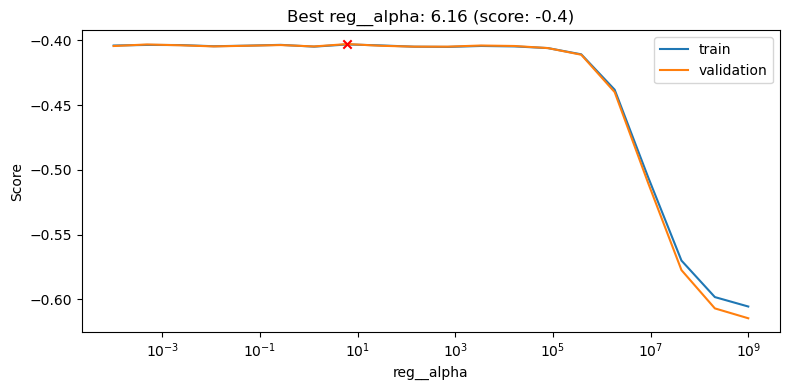

In [16]:
n = "ridge_unweighted_dummy"
grid = {
    "scaler": [QuantileTransformer(output_distribution="normal")],
    # "sample_weight": [sample_weights_tv],
    "reg__alpha": np.logspace(-4, 9, num=20),
}
model, y_transform, y_pred, res = eval_model(
    n,
    Ridge(),
    grid,
    X_tv,
    y_tv,
    y_tv ** 2,
    X_test,
    y_test,
    np.full_like(y_test, 1),
    n_splits=1,
    verbose=2,
)
display_graph(model, "reg__alpha", xlog=True, param_prefix="")
ridge_unweighted_dummy = (n, y_pred, res)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Total training time: 29.77s
Mean fit time: 0.86s
----
Predicting train...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 0.83s
Score (train): 0.77
MAE (train): 1.11
RMSE (train): 2.58
----
Predicting test...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 0.37s
Score (test): 0.76
MAE (test): 1.12
RMSE (test): 2.64


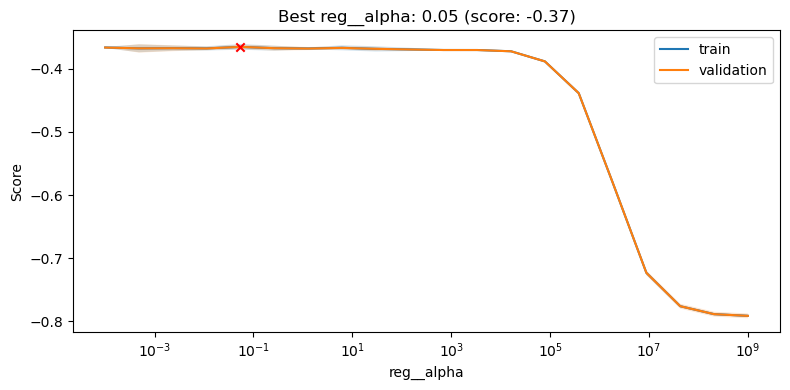

In [17]:
n = "ridge_unweighted_kfold"
grid = {
    "scaler": [QuantileTransformer(output_distribution="normal")],
    # "sample_weight": [sample_weights_tv],
    "reg__alpha": np.logspace(-4, 9, num=20),
}
model, y_transform, y_pred, res = eval_model(
    n,
    Ridge(),
    grid,
    X_tv,
    y_tv,
    np.full_like(y_tv, 1),
    X_test,
    y_test,
    np.full_like(y_test, 1),
    n_splits=3,
    kfold=True,
    verbose=2,
)
display_graph(model, "reg__alpha", xlog=True, param_prefix="")
ridge_unweighted_kfold = (n, y_pred, res)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Total training time: 30.19s
Mean fit time: 0.91s
----
Predicting train...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 0.78s
Score (train): 0.77
MAE (train): 1.11
RMSE (train): 2.58
----
Predicting test...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 0.36s
Score (test): 0.76
MAE (test): 1.12
RMSE (test): 2.64


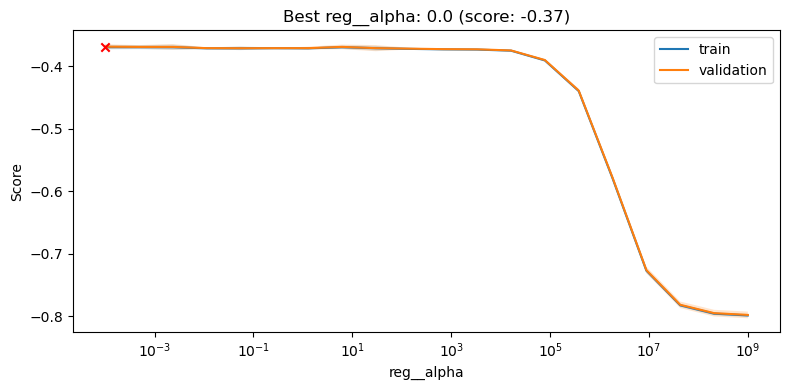

In [18]:
n = "ridge_unweighted"
grid = {
    "scaler": [QuantileTransformer(output_distribution="normal")],
    # "sample_weight": [sample_weights_tv],
    "reg__alpha": np.logspace(-4, 9, num=20),
}
model, y_transform, y_pred, res = eval_model(
    n,
    Ridge(),
    grid,
    X_tv,
    y_tv,
    np.full_like(y_tv, 1),
    X_test,
    y_test,
    np.full_like(y_test, 1),
    n_splits=3,
    verbose=2,
)
display_graph(model, "reg__alpha", xlog=True, param_prefix="")
ridge_unweighted = (n, y_pred, res)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Total training time: 30.91s
Mean fit time: 0.93s
----
Predicting train...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 0.78s
Score (train): 0.79
MAE (train): 1.08
RMSE (train): 2.47
----
Predicting test...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 0.35s
Score (test): 0.78
MAE (test): 1.09
RMSE (test): 2.54


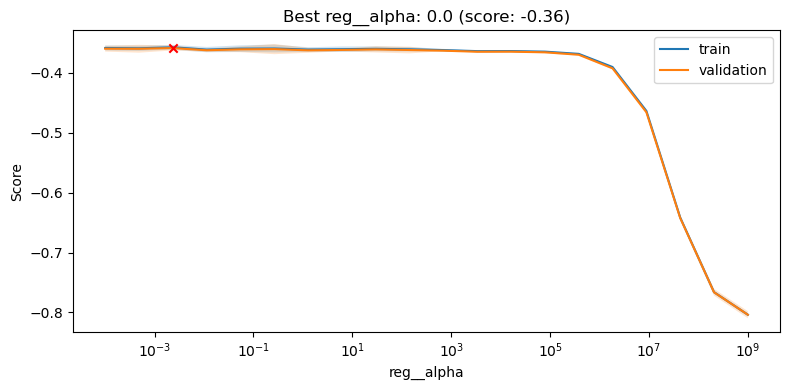

In [19]:
n = "ridge_weighted"
grid = {
    "scaler": [QuantileTransformer(output_distribution="normal")],
    # "sample_weight": [sample_weights_tv],
    "reg__alpha": np.logspace(-4, 9, num=20),
}
model, y_transform, y_pred, res = eval_model(
    n,
    Ridge(),
    grid,
    X_tv,
    y_tv,
    sample_weights_tv,
    X_test,
    y_test,
    sample_weights_test,
    n_splits=3,
    verbose=2,
)
display_graph(model, "reg__alpha", xlog=True, param_prefix="")
ridge_weighted = (n, y_pred, res)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Total training time: 6.11s
Mean fit time: 0.29s
----
Predicting train...
Prediction time: 0.02s
Score (train): 0.6
MAE (train): 1.55
RMSE (train): 4.02
----
Predicting test...
Prediction time: 0.02s
Score (test): 0.68
MAE (test): 1.46
RMSE (test): 3.65


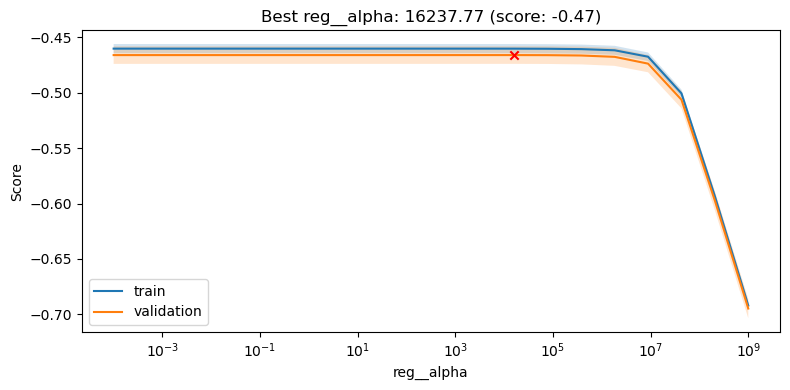

In [20]:
n = "ridge_weighted_2"
grid = {
    "scaler": [StandardScaler().set_fit_request(sample_weight=True)],
    # "sample_weight": [sample_weights_tv],
    "reg__alpha": np.logspace(-4, 9, num=20),
}
model, y_transform, y_pred, res = eval_model(
    n,
    Ridge(),
    grid,
    X_tv,
    y_tv,
    sample_weights_tv_2,
    X_test,
    y_test,
    sample_weights_test,
    n_splits=3,
    y_scaler=StandardScaler(),
    verbose=2,
)
display_graph(model, "reg__alpha", xlog=True, param_prefix="")
ridge_weighted_2 = (n, y_pred, res)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Total training time: 880.82s
Mean fit time: 110.36s
----
Predicting train...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 3.78s
Score (train): 0.92
MAE (train): 0.61
RMSE (train): 0.88
----
Predicting test...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 1.59s
Score (test): 0.88
MAE (test): 0.76
RMSE (test): 1.35


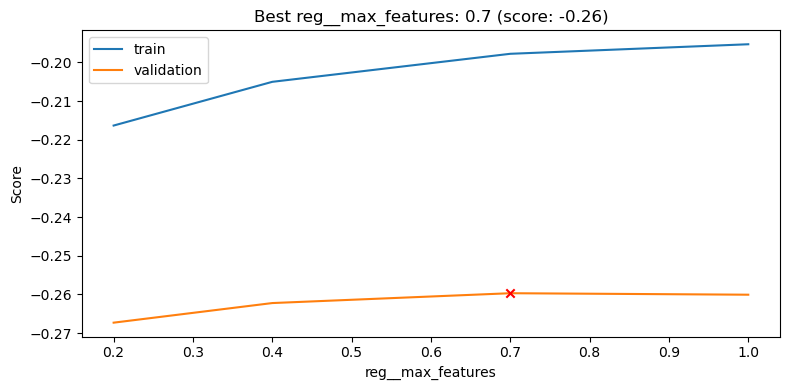

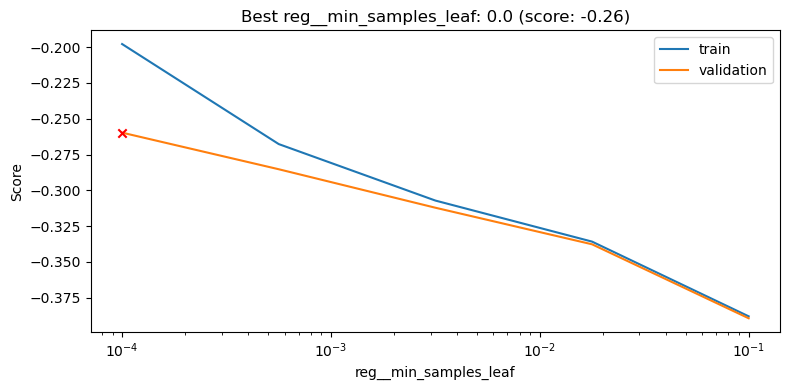

In [22]:
n = "rf_weighted"
grid = {
    "scaler": [QuantileTransformer(output_distribution="normal")],
    "reg__n_estimators": [100],
    "reg__max_features": [0.2, 0.4, 0.7, 1.0],
    "reg__min_samples_leaf": np.logspace(-4, -1, num=5),
}
model, y_transform, y_pred, res = eval_model(
    n,
    RandomForestRegressor(),
    grid,
    X_tv,
    y_tv,
    sample_weights_tv,
    X_test,
    y_test,
    sample_weights_test,
    n_splits=1,
    verbose=2,
)
display_graph(model, "reg__max_features", xlog=False, param_prefix="")
display_graph(model, "reg__min_samples_leaf", xlog=True, param_prefix="")
rf_weighted = (n, y_pred, res)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
Total training time: 662.17s
Mean fit time: 260.52s
----
Predicting train...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 8.79s
Score (train): 0.98
MAE (train): 0.29
RMSE (train): 0.21
----
Predicting test...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 3.31s
Score (test): 0.9
MAE (test): 0.69
RMSE (test): 1.14


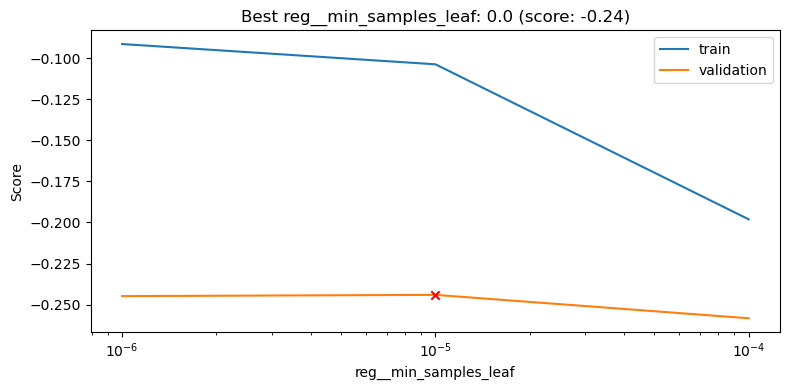

In [23]:
n = "rf_weighted"
grid = {
    "scaler": [QuantileTransformer(output_distribution="normal")],
    "reg__n_estimators": [100],
    "reg__max_features": [0.7],
    "reg__min_samples_leaf": np.logspace(-6, -4, num=3),
}
model, y_transform, y_pred, res = eval_model(
    n,
    RandomForestRegressor(),
    grid,
    X_tv,
    y_tv,
    sample_weights_tv,
    X_test,
    y_test,
    sample_weights_test,
    n_splits=1,
    verbose=2,
)
display_graph(model, "reg__min_samples_leaf", xlog=True, param_prefix="")
rf_weighted = (n, y_pred, res)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Total training time: 227.76s
Mean fit time: 100.02s
----
Predicting train...


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Prediction time: 2.35s
Score (train): 0.75
MAE (train): 1.21
RMSE (train): 2.55
----
Predicting test...
Prediction time: 1.02s
Score (test): 0.82
MAE (test): 0.99
RMSE (test): 2.13


C:\Users\mayeu\miniconda3\envs\adsml\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


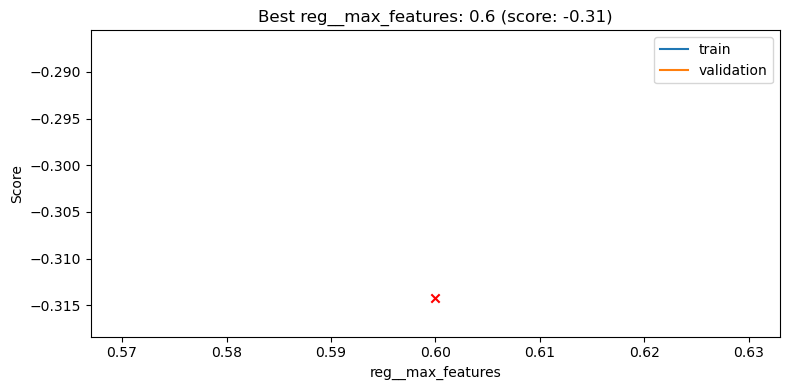

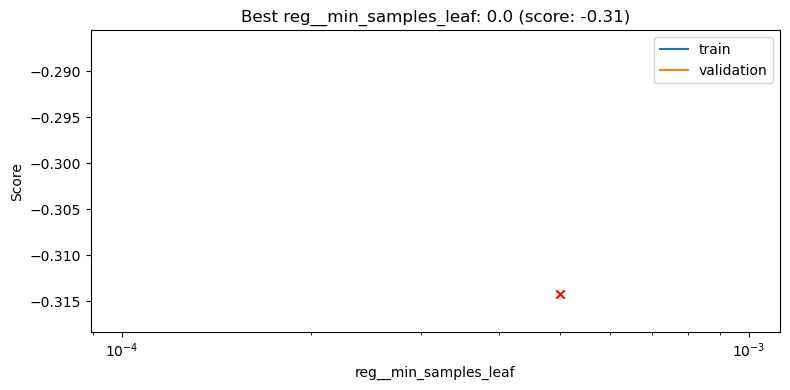

In [24]:
n = "rf_weighted_2"
grid = {
    "scaler": [QuantileTransformer(output_distribution="normal")],
    "reg__n_estimators": [64],
    "reg__max_features": [0.6],
    "reg__min_samples_leaf": [0.0005],
}
model, y_transform, y_pred, res = eval_model(
    n,
    RandomForestRegressor(),
    grid,
    X_tv,
    y_tv,
    sample_weights_tv_2,
    X_test,
    y_test,
    sample_weights_test,
    n_splits=3,
    verbose=2,
)
display_graph(model, "reg__max_features", xlog=False, param_prefix="")
display_graph(model, "reg__min_samples_leaf", xlog=True, param_prefix="")
rf_weighted_2 = (n, y_pred, res)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Total training time: 190.39s
Mean fit time: 77.07s
----
Predicting train...
Prediction time: 1.86s
Score (train): 0.86
MAE (train): 0.87
RMSE (train): 1.66
----
Predicting test...
Prediction time: 0.81s
Score (test): 0.84
MAE (test): 0.9
RMSE (test): 1.8


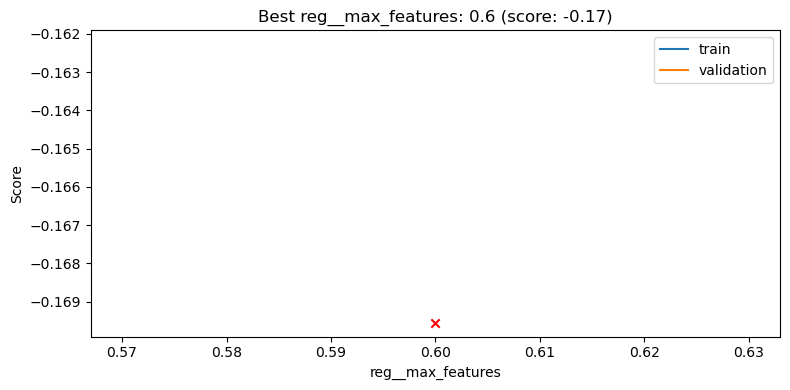

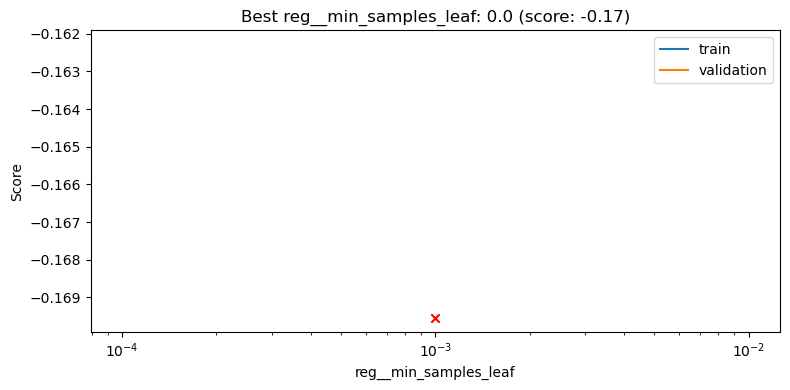

In [25]:
n = "rf_weighted_standard"
grid = {
    "scaler": [QuantileTransformer(output_distribution="normal")],
    "reg__n_estimators": [64],
    "reg__max_features": [0.6],
    "reg__min_samples_leaf": [0.001],
}
model, y_transform, y_pred, res = eval_model(
    n,
    RandomForestRegressor(),
    grid,
    X_tv,
    y_tv,
    sample_weights_tv,
    X_test,
    y_test,
    sample_weights_test,
    n_splits=1,
    verbose=2,
    y_scaler=RobustScaler(),
)
display_graph(model, "reg__max_features", xlog=False, param_prefix="")
display_graph(model, "reg__min_samples_leaf", xlog=True, param_prefix="")
rf_weighted_standard = (n, y_pred, res)

In [26]:
results = []

df_pred = test_split[["GPP"]].copy()
df_pred.rename(columns={"GPP": "True GPP"}, inplace=True)

for (model_name, y_pred, res) in [
    ridge_weighted,
    ridge_weighted_2,
    rf_weighted,
    rf_weighted_2,
    ridge_unweighted,
    ridge_unweighted_dummy,
    rf_weighted_standard,
    ridge_unweighted_kfold,
]:
    results.append(res)
    df_pred[model_name] = y_pred

# Persist the predictions
df_pred.to_csv(predictions_path)
print(df_pred.shape)

# Persist the metrics
results_df = (
    pd.DataFrame(results)
    # .drop_duplicates(subset=["model"], keep="last")
    .set_index("model")
)
results_df.to_csv(results_path)
results_df

(63551, 9)


,pred_time_train,R2_train,MAE_train,RMSE_train,pred_time_test,R2_test,MAE_test,RMSE_test
model,,,,,,,,
ridge_weighted,0.78,0.79,1.08,2.47,0.35,0.78,1.09,2.54
ridge_weighted_2,0.02,0.60,1.55,4.02,0.02,0.68,1.46,3.65
rf_weighted,8.79,0.98,0.29,0.21,3.31,0.90,0.69,1.14
rf_weighted_2,2.35,0.75,1.21,2.55,1.02,0.82,0.99,2.13
ridge_unweighted,0.78,0.77,1.11,2.58,0.36,0.76,1.12,2.64
ridge_unweighted_dummy,0.73,0.54,1.60,4.21,0.31,0.65,1.49,3.90
rf_weighted_standard,1.86,0.86,0.87,1.66,0.81,0.84,0.90,1.80
ridge_unweighted_kfold,0.83,0.77,1.11,2.58,0.37,0.76,1.12,2.64


In [27]:
# df_pred = pd.read_csv(predictions_path)
# df_pred["date"] = pd.to_datetime(df_pred["date"])
# df_pred.set_index(["site", "date"], inplace=True)
df_err = df_pred.sub(df_pred["True GPP"], axis=0)
# df_pred

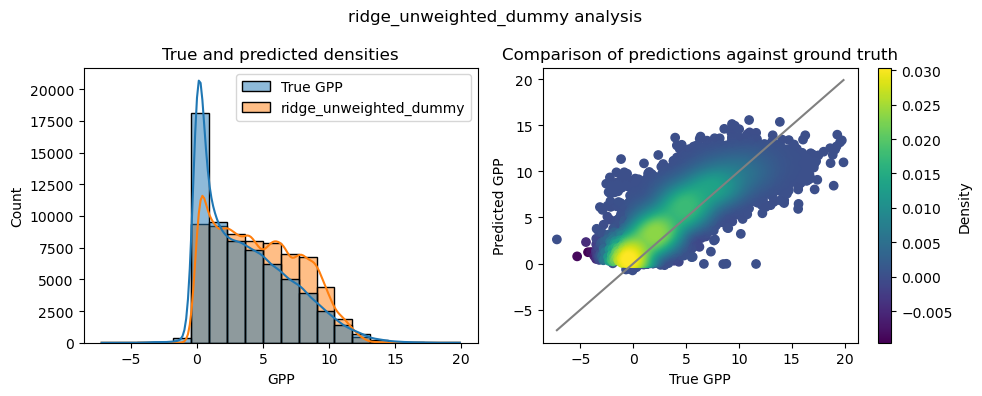

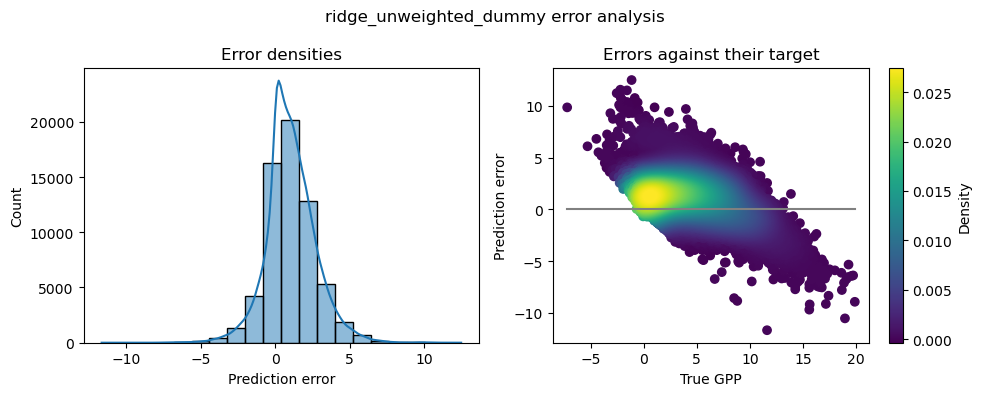

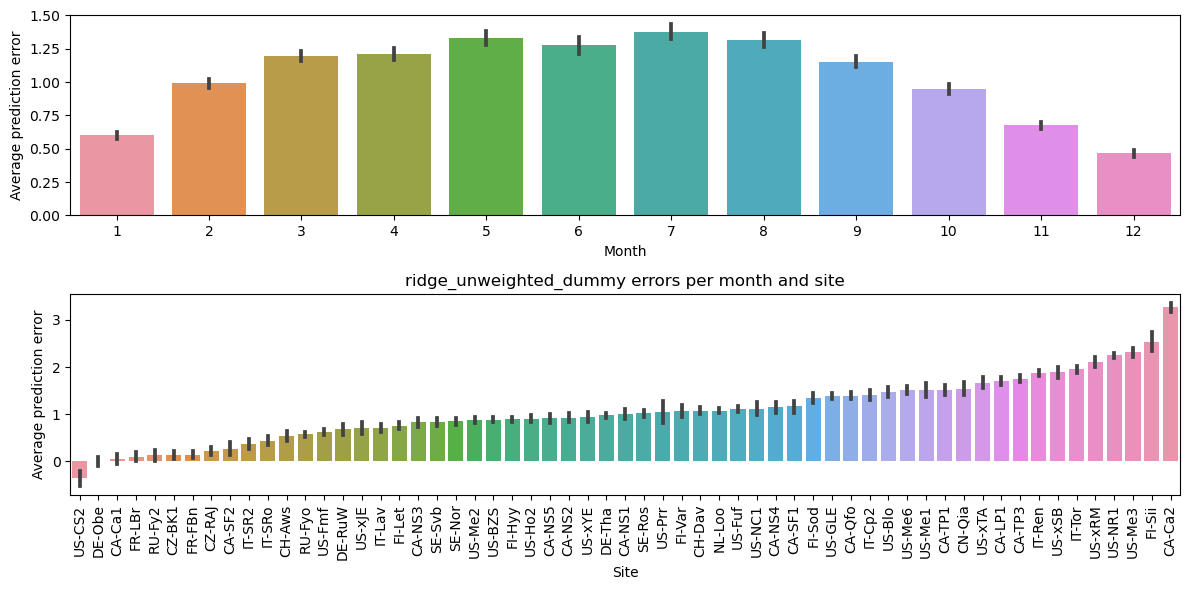

In [28]:
n = "ridge_unweighted_dummy"
pred_plot(df_pred, n)
err_plot(df_pred, df_err, n)
error_per_month_and_site(df_err, n)

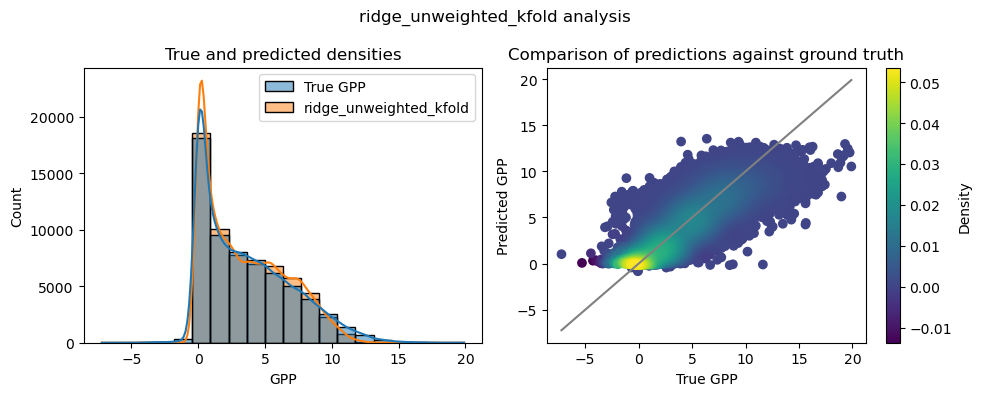

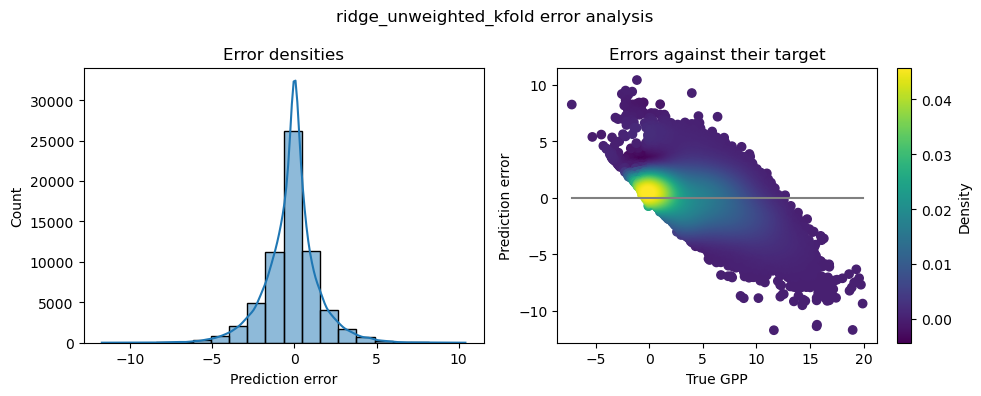

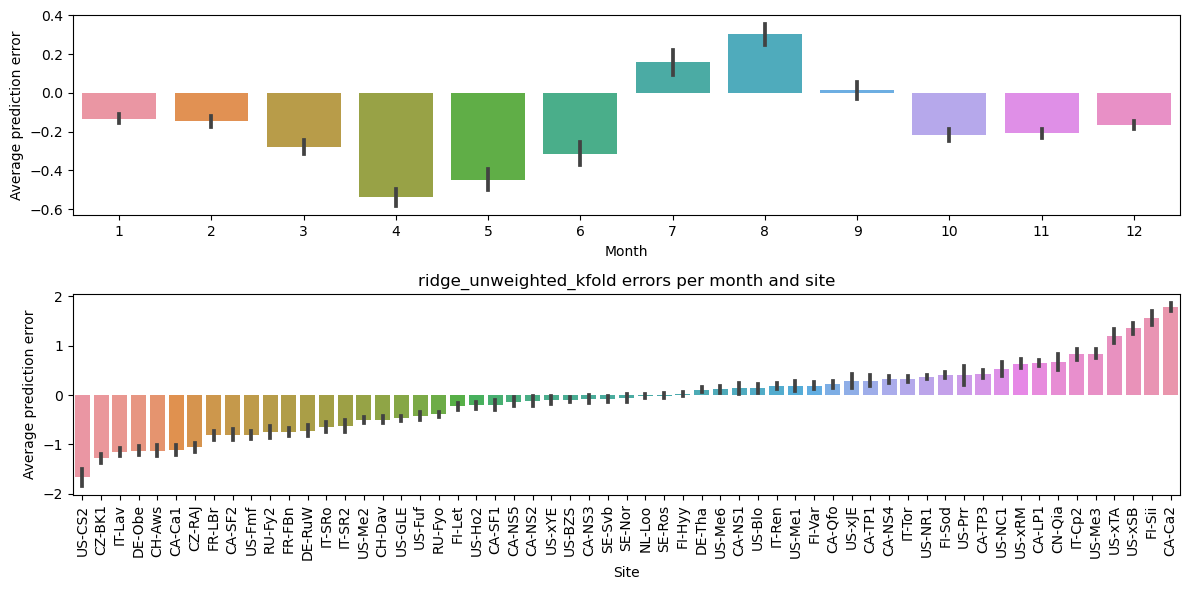

In [29]:
n = "ridge_unweighted_kfold"
pred_plot(df_pred, n)
err_plot(df_pred, df_err, n)
error_per_month_and_site(df_err, n)

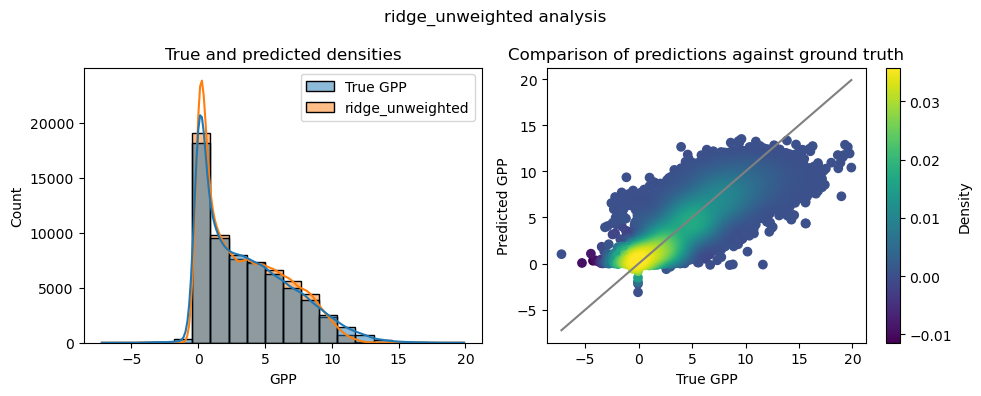

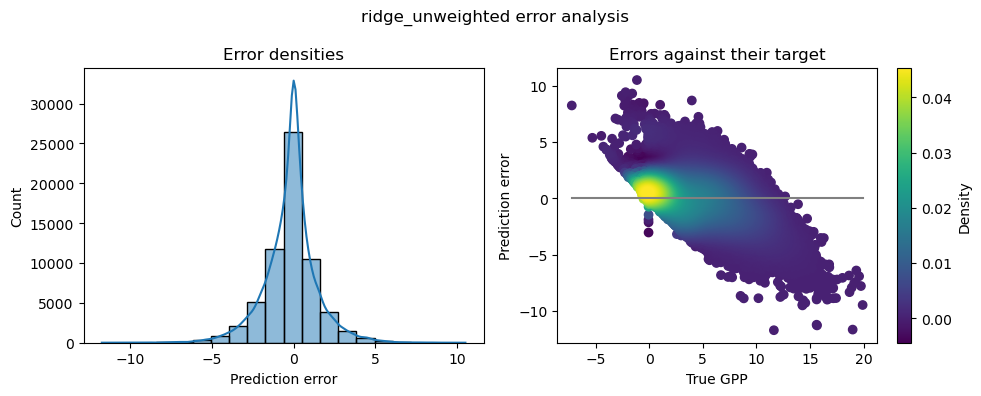

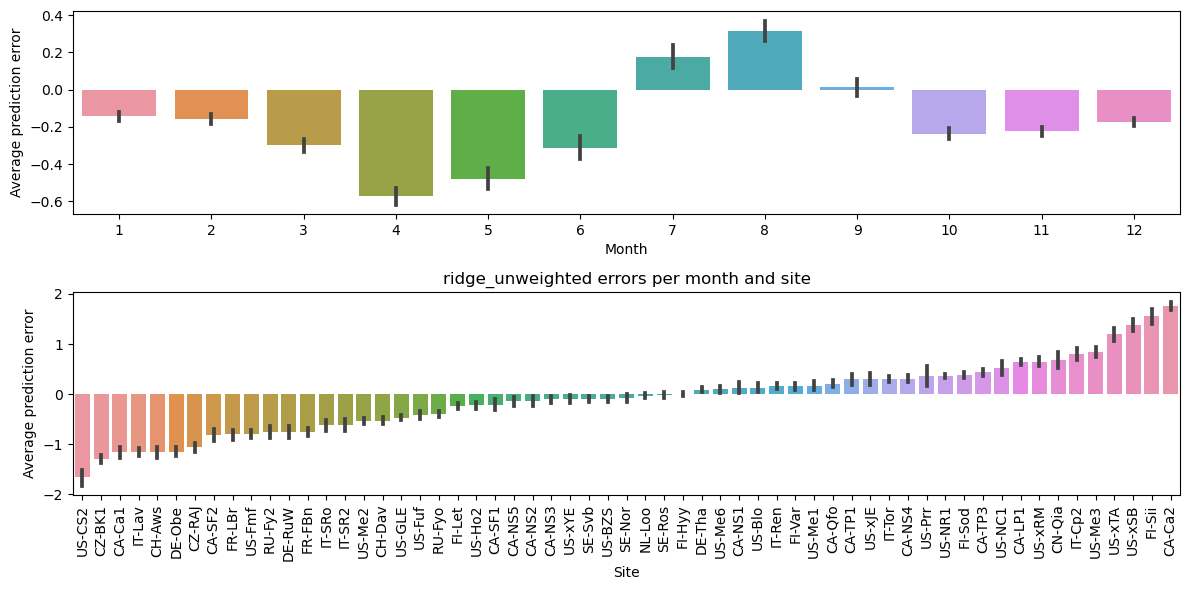

In [30]:
n = "ridge_unweighted"
pred_plot(df_pred, n)
err_plot(df_pred, df_err, n)
error_per_month_and_site(df_err, n)

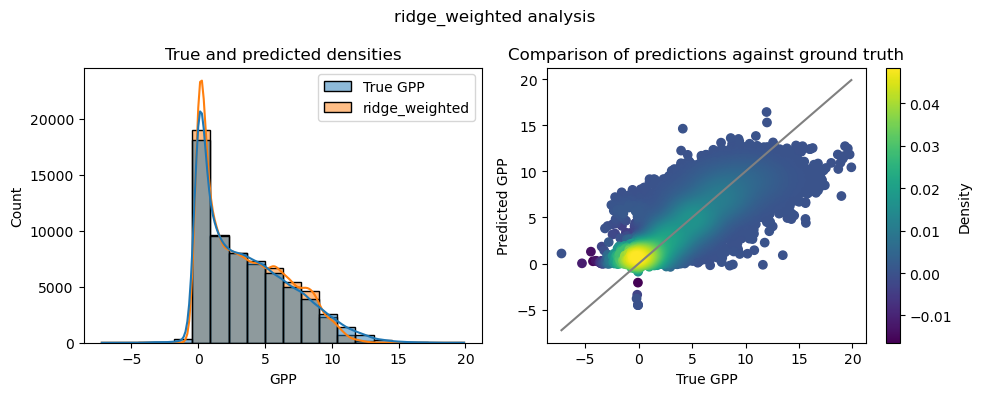

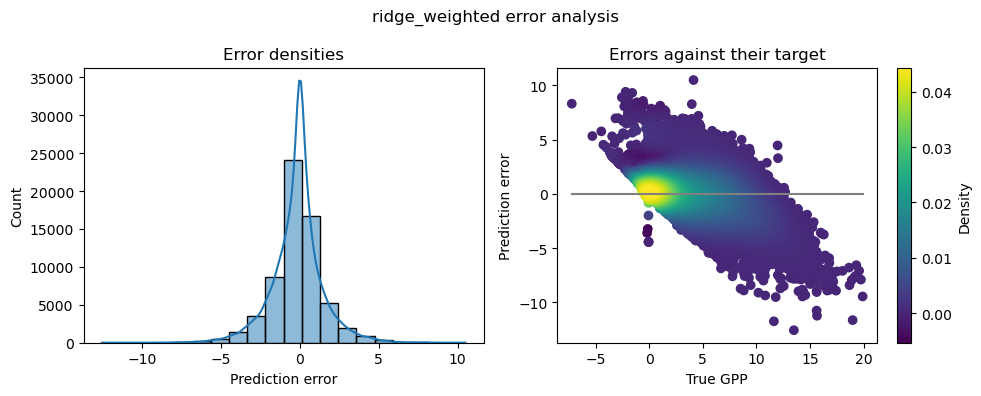

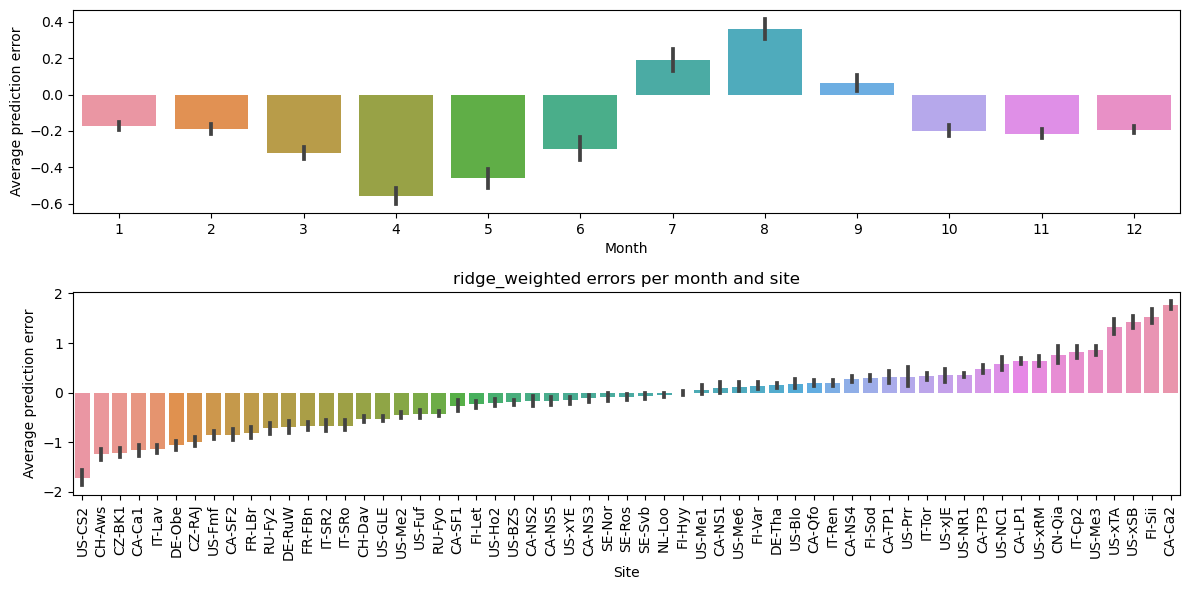

In [31]:
n = "ridge_weighted"
pred_plot(df_pred, n)
err_plot(df_pred, df_err, n)
error_per_month_and_site(df_err, n)

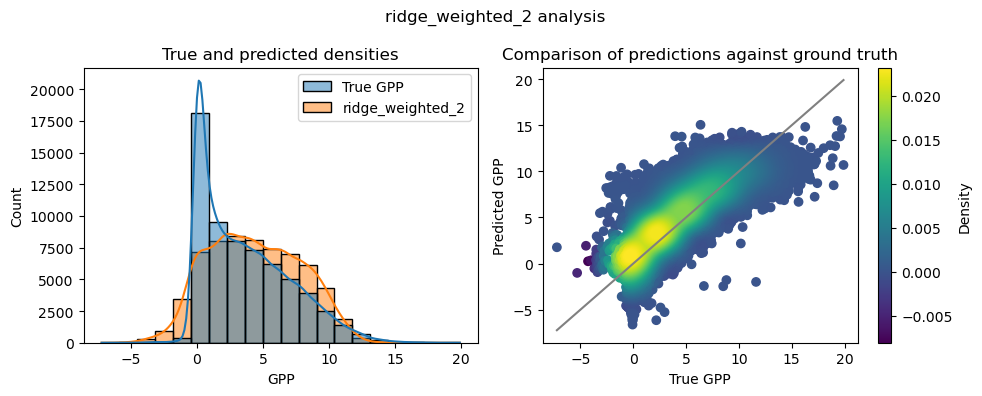

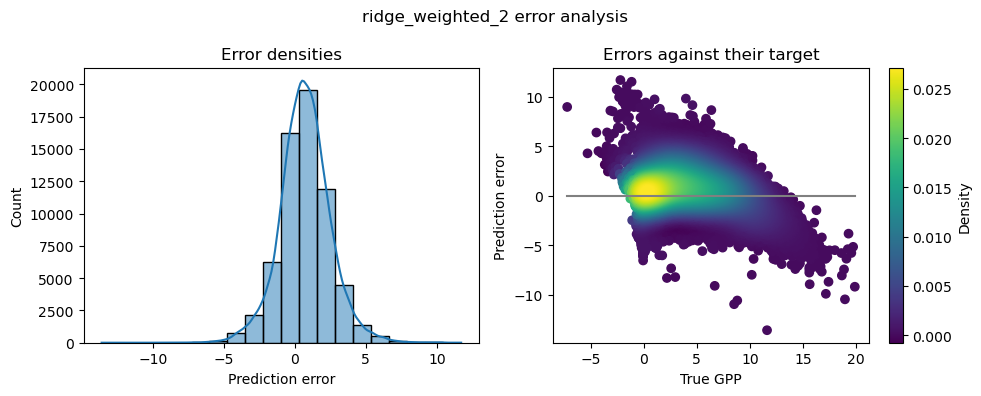

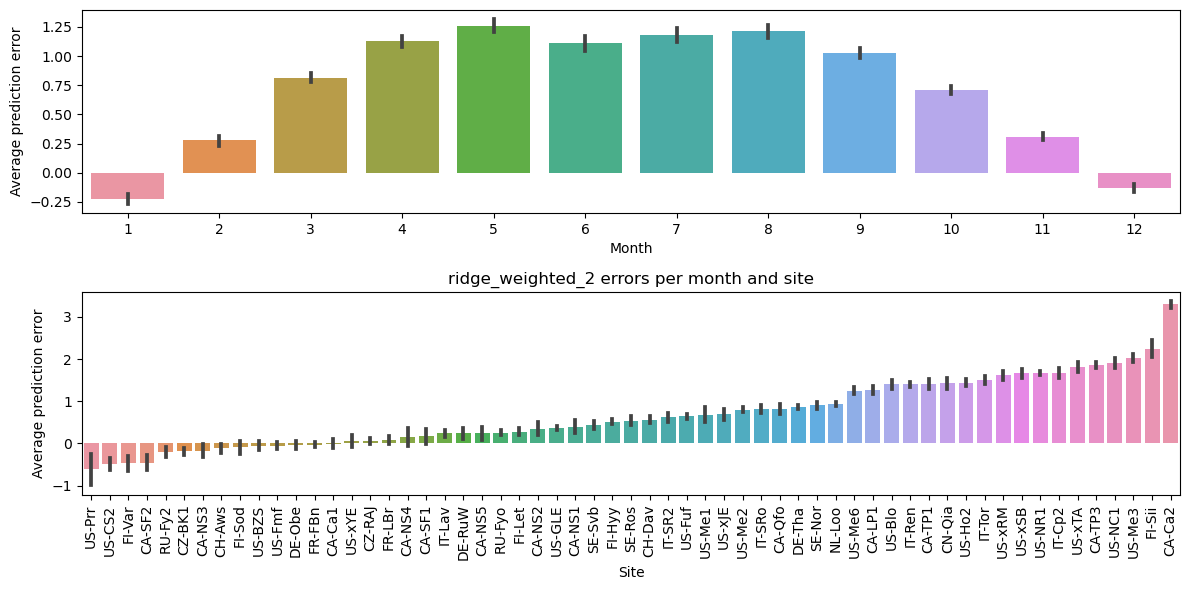

In [32]:
n = "ridge_weighted_2"
pred_plot(df_pred, n)
err_plot(df_pred, df_err, n)
error_per_month_and_site(df_err, n)

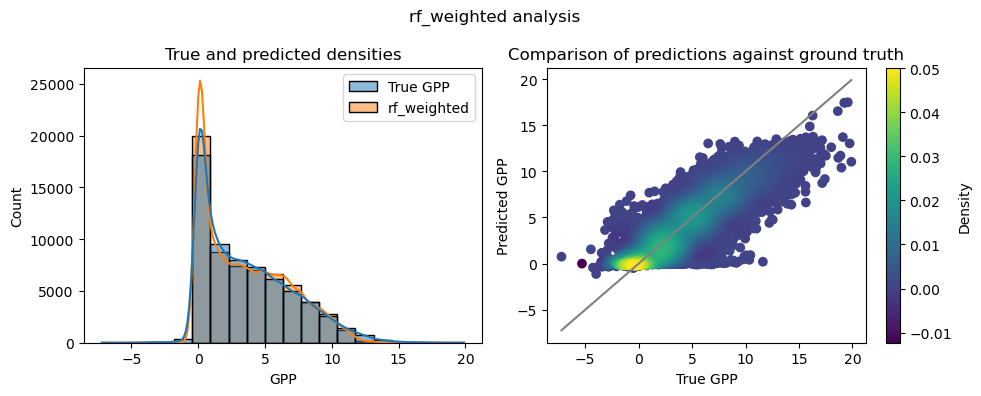

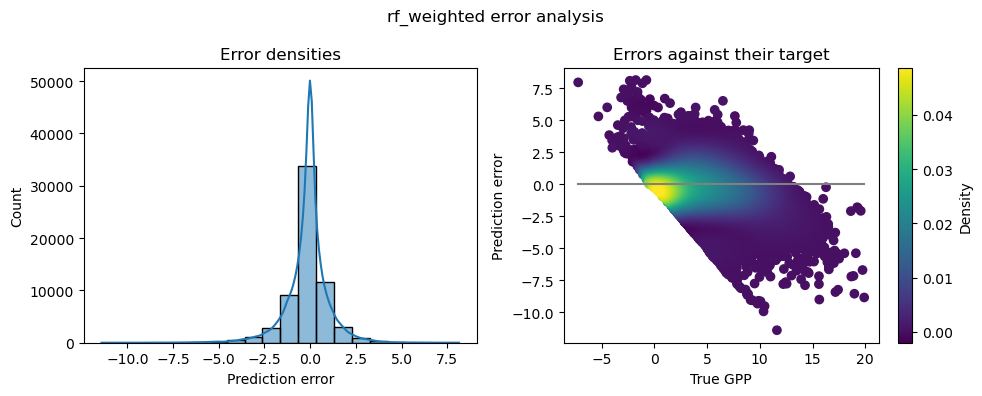

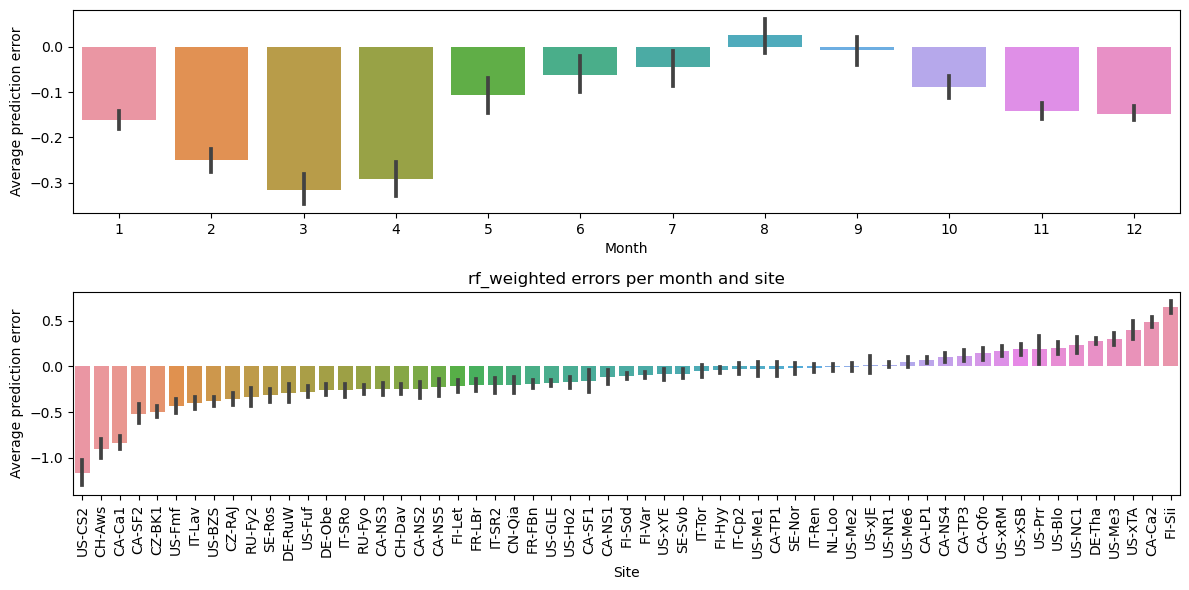

In [36]:
n = "rf_weighted"
pred_plot(df_pred, n)
err_plot(df_pred, df_err, n)
error_per_month_and_site(df_err, n)

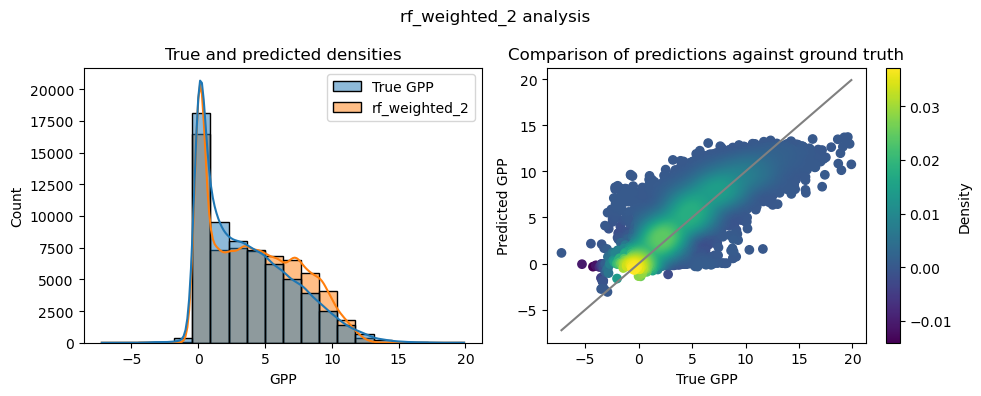

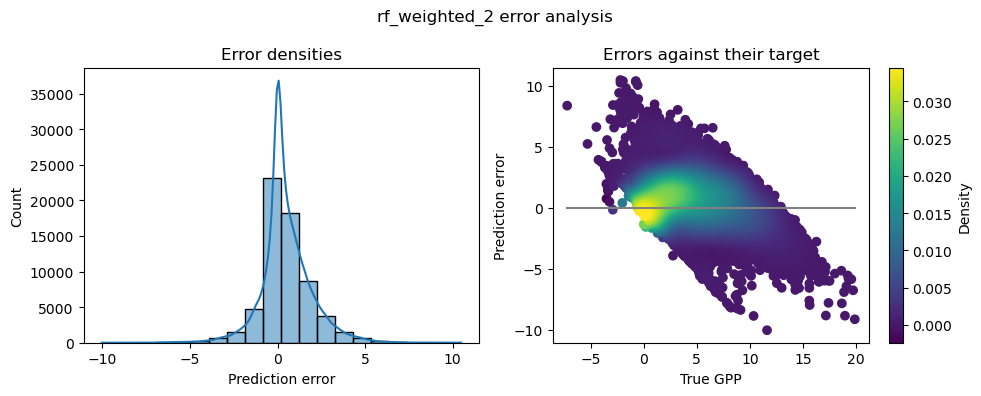

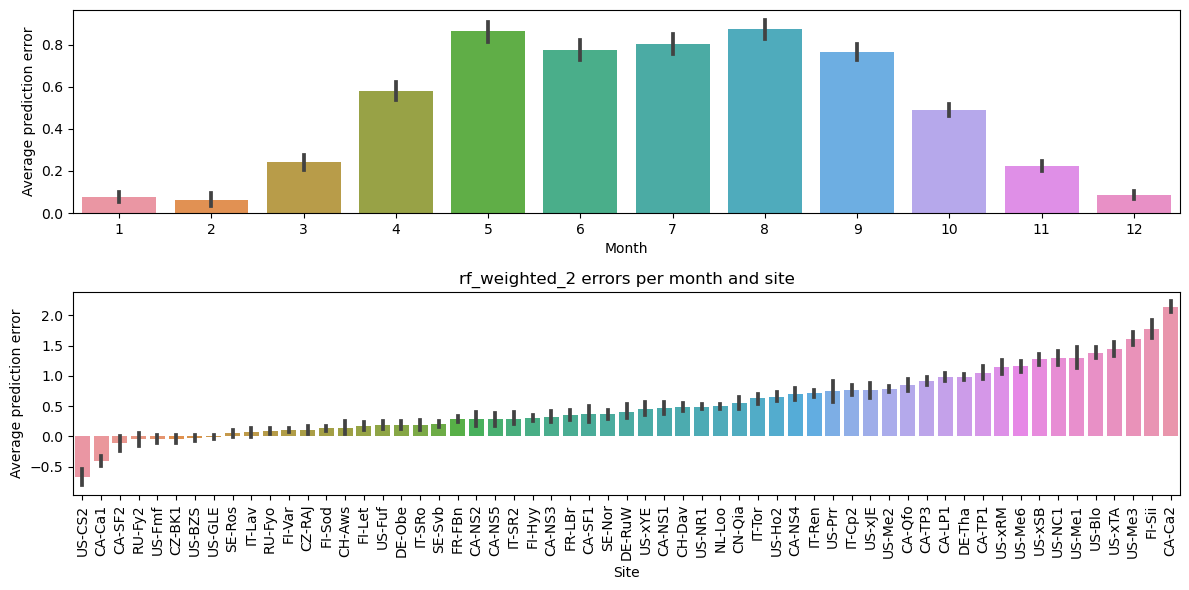

In [37]:
n = "rf_weighted_2"
pred_plot(df_pred, n)
err_plot(df_pred, df_err, n)
error_per_month_and_site(df_err, n)

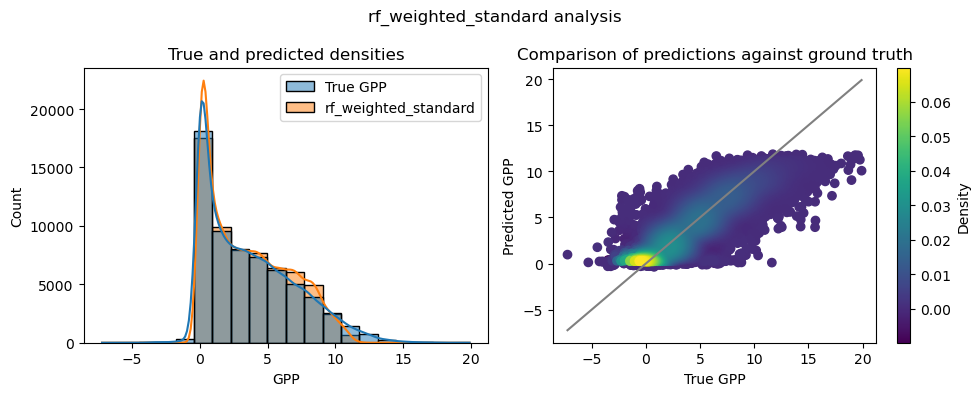

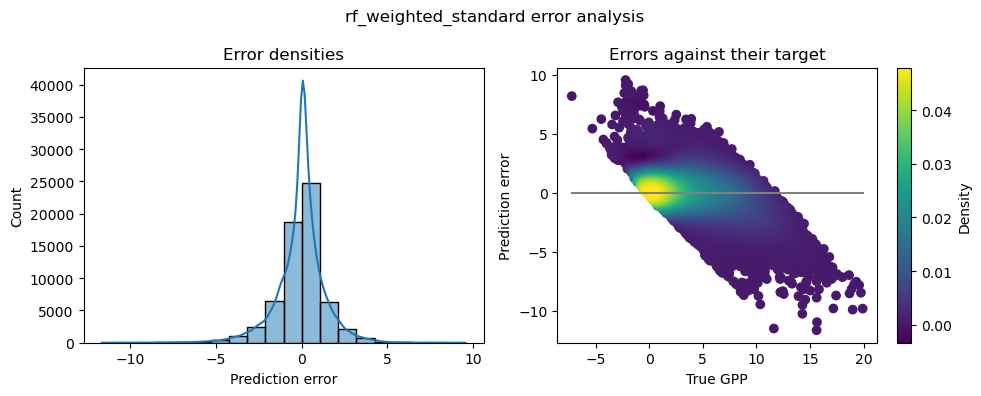

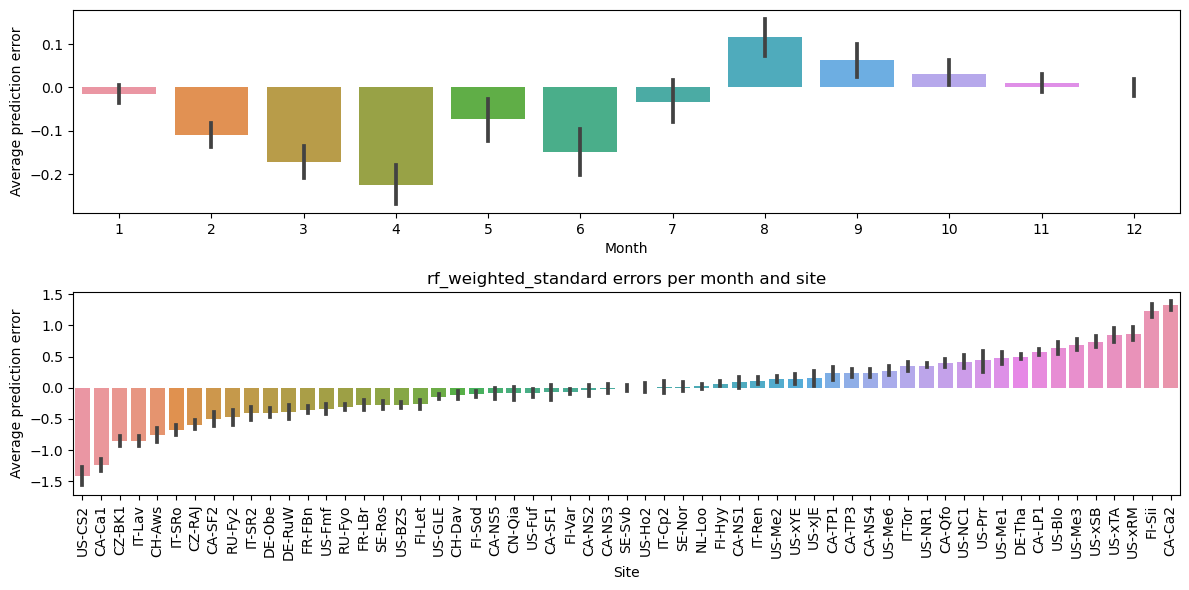

In [38]:
n = "rf_weighted_standard"
pred_plot(df_pred, n)
err_plot(df_pred, df_err, n)
error_per_month_and_site(df_err, n)

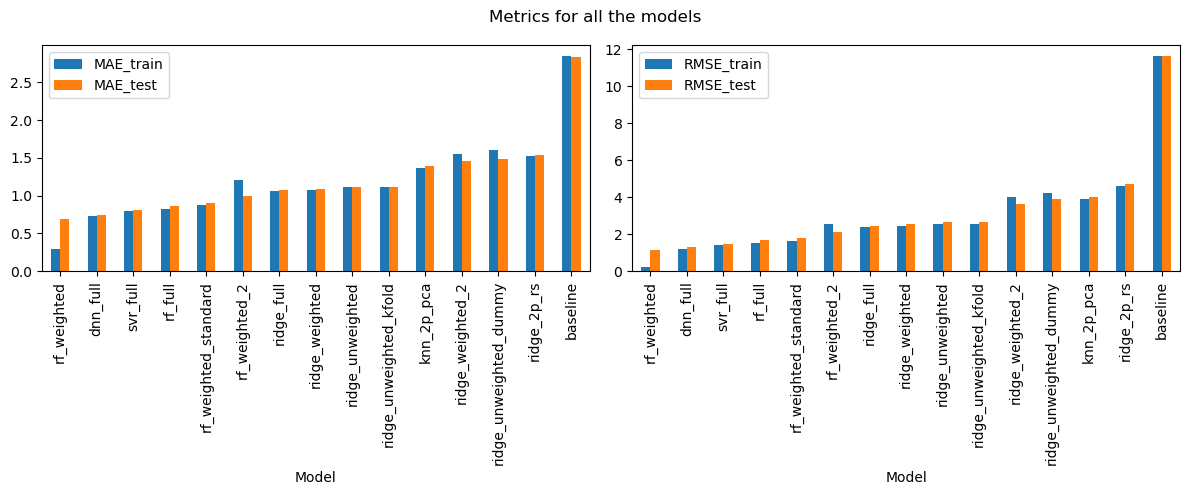

In [39]:
results_standard_df = pd.read_csv(results_standard_path).set_index("model")
results_df = pd.read_csv(results_path).set_index("model")
results_df = pd.concat([results_df, results_standard_df])
plot_metrics(results_df, ["train", "test"])